In [1]:
import datetime

import geopandas as gpd
import pandas as pd

import folium
from matplotlib import pyplot as plt
import process as fe
import shapely
from scipy.stats import zscore
import numpy as np

# Interactive Fare Evasion Map

This notebook will demonostrate the creation of a simple `leaflet.js` map representing fare evasion arrests using a data set created in the `Filter Arrests` and the `folium` python package

In [2]:
# Load data using helper functions

stations, evasions, census, lines, nyc = fe.load_all_data()

Depending on the way the `evasions` DataFrame is made, the date filtering below may not be necessary, but it allows the data in the map to be fine-tuned without changing the saved data set.

In [3]:
# We only want arrests after 2010
evasions = evasions[evasions['ARREST_DATE'] >= datetime.datetime(2010, 3, 7, 0, 0)]

stations = fe.populate_arrests(stations, evasions)

stations

,complex_nm,trains,station_ct,bcode,stop_lat,stop_lon,tot2007,tot2008,tot2009,tot2010,...,avwken11,avwken12,avwken13,avwken14,avwken15,avwken16,avwken17,srv_notes,geometry,arrests
complex_id,,,,,,,,,,,,,,,,,,,,,
bx001,138 St-Grand Concourse,4 5,1,36005,40.813224,-73.929849,800595.0,864369.0,887662.0,898509.0,...,2526.0,2648.0,2540.0,3017.0,3136.0,3123.0,2793,NaN,POINT (-73.92985 40.81322),153.0
bx002,149 St-Grand Concourse,2 4 5,2,36005,40.818375,-73.927351,3112547.0,3454530.0,3660150.0,3979328.0,...,14022.0,13024.0,14202.0,15326.0,13683.0,12797.0,12623,NaN,POINT (-73.92735 40.81838),572.0
bx003,161 St-Yankee Stadium,B D 4,2,36005,40.827905,-73.925651,7836990.0,8576546.0,8410256.0,8434247.0,...,34258.0,35820.0,35071.0,36176.0,36969.0,35171.0,33398,NaN,POINT (-73.92565 40.82791),3584.0
bx004,167 St,4,1,36005,40.835537,-73.921400,2715327.0,2876058.0,2892398.0,2931947.0,...,11089.0,11188.0,10176.0,10417.0,11942.0,11579.0,9981,NaN,POINT (-73.92140 40.83554),650.0
bx005,167 St,B D,1,36005,40.833771,-73.918440,2834640.0,2920517.0,2874428.0,2907900.0,...,11956.0,11924.0,12887.0,13220.0,12890.0,12775.0,12682,NaN,POINT (-73.91844 40.83377),565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
qn074,Sutphin Blvd-Archer Av-JFK Airport,E J Z,1,36081,40.700486,-73.807969,6064612.0,6433286.0,6418547.0,6447287.0,...,24498.0,25388.0,26184.0,28862.0,28383.0,28587.0,25234,NaN,POINT (-73.80797 40.70049),1698.0
qn075,Vernon Blvd-Jackson Av,7,1,36081,40.742626,-73.953581,2414808.0,2967358.0,2939995.0,3110952.0,...,9441.0,8612.0,9491.0,10347.0,12582.0,14981.0,14901,NaN,POINT (-73.95358 40.74263),11.0
qn076,Woodhaven Blvd,J Z,1,36081,40.693879,-73.851576,1180476.0,1269407.0,1285768.0,1285323.0,...,4227.0,3835.0,4255.0,5226.0,5388.0,5099.0,3884,NaN,POINT (-73.85158 40.69388),104.0


If you just need a static map, the helper function `plot_num_arrests_station` can take care of that. Passing `save=False` stops the figure from automatically being saved. 

/Users/NickSawhney/Desktop/fare_evasion/nyc/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


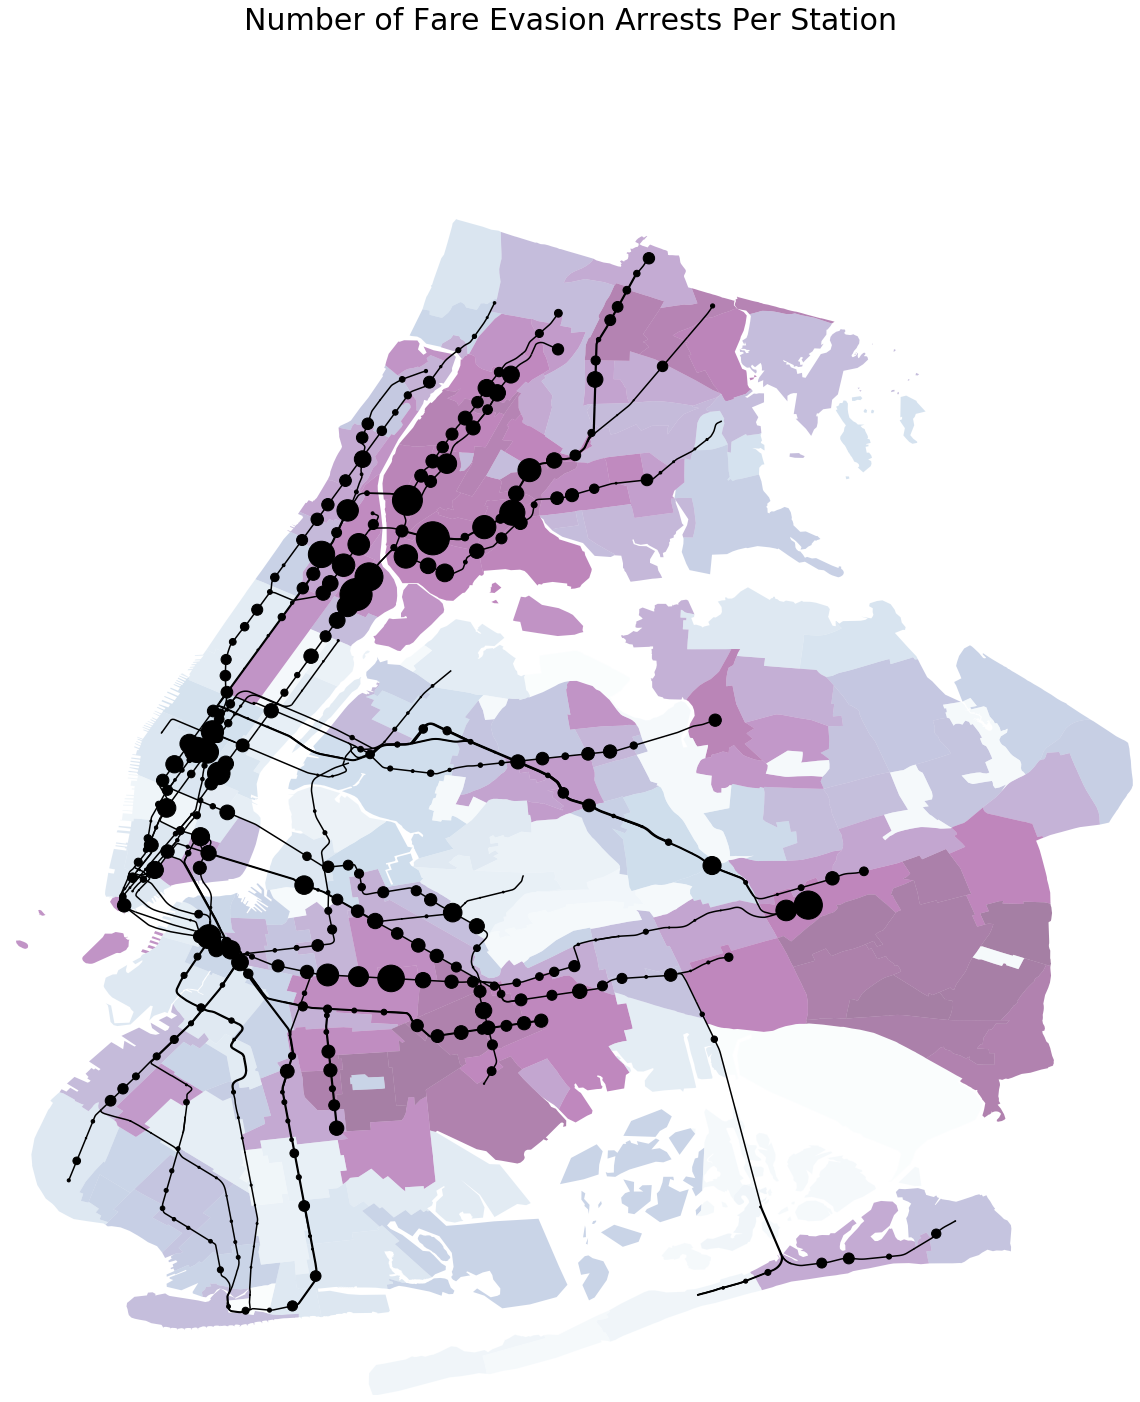

In [4]:
fe.plot_num_arrests_station(stations, lines, nyc, census, save=False, mult=0.25)

## Making and populating the map 

First, a folium `Map` object is created. All the elements of the map (subway stations, shapes, etc) are added to this map object.

In [5]:
m = folium.Map(location=(stations.loc['qn009'].geometry.y, stations.loc['qn009'].geometry.x),
               zoom_start=13,
               tiles='CartoDB positron')

I wrote functions to add subway lines and stations to the map such that they accept a single row of data, which allows them to be used in combination with pandas' `DataFrame.apply`. I really enjoy this way of coding since it lets me change the data set and map behavior independently of each other, and only the folium map object changes. It made experimental coding and fine-tuning the parameters a lot easier than it would have been with for loops and row iteration (and I think the code is cleaner as well). 

In [6]:
# TODO: Document, Move these functions to their own module, called something like `mapmaking.py`

def add_to_map(row, mp, tooltip='Click Here'):
    
    lat = row['stop_lat']
    long = row['stop_lon']
        
#     print(row['arrests'], row['arrests'] / 100)

    popup=folium.Popup(f"<i>{row['complex_nm']}</i><br> has had {int(row['arrests'])} arrests since 2010")


    tooltip = row['complex_nm']
        
    folium.Circle([lat, long], 
                  popup=popup, 
                  color='red',# if arrest_z > 0 else 'blue',
                  radius=row['arrests'] / 8 + 2,
                  weight=1.5,
                  fill=True,
                  tooltip=tooltip).add_to(mp)

In [7]:
def add_line_to_map(row, mp):
    geom = row.geometry.__geo_interface__
    
    lns = [(y, x) for (x, y) in geom['coordinates']]
    
    folium.PolyLine(lns, color=row['color']).add_to(mp)
    
    return row['color']

Here I just add the official colors for each subway line so that they are easily identifiable on the map

In [8]:
line_groups = [line for line in lines.groupby('rt_symbol').groups]
colors = ['#EE352E', '#00933C', '#B933AD', '#0039A6', '#FF6319', '#6CBE45', '#996633', '#A7A9AC', '#FCCC0A']

line_colors = {line:color for line, color in zip(line_groups, colors)}

lines['color'] = lines['rt_symbol'].apply(lambda x: line_colors[x])

And finally, here I actually populate the map!

In [9]:
lines.apply(add_line_to_map, axis=1, args=(m,));

In [10]:
# Sort by descending arrests so larger circles are placed first, 
# enabling the user to click on every circle even if it inscribes another
st = stations.sort_values(by='arrests', ascending=False)

st.apply(add_to_map, axis=1, args=(m,));

The map can be explored by opening the `index.html` in a browser (recommended) or by calling the jupyter notebook representation of the map object (below).

In [11]:
m.save('index.html')

In [12]:
m